In [1]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

pd.options.display.max_columns = 200

In [2]:
df = pd.read_csv('data/train_new.csv').rename({'target': 'value'}, axis=1)

In [3]:
df['Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, рубли'] = df['Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, рубли'].replace(' ', 0).astype(float)

In [4]:
def create_features(df):

    week_info = df.groupby('Период_неделя')['value'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    df = df.merge(week_info, how='left', right_index=True, left_on='Период_неделя')
    df['week_sum'] -= df['value']
    df['week_count'] -= 1
    df['feature_mean_week'] = df['week_sum'] / df['week_count']
    df['feature_mean_week_norm'] = df['feature_mean_week'] / df['value']

    df['feature_week'] = df['Период_неделя']
    df['feature_выписки'] = df['выписки врачами_Выписки '].shift(1)

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['value'].shift(i) / df['value'].shift(i+4)

    for i in range(28):
        df[f'target_{i+1}'] = df['value'].shift(-i) / df['value'].shift(1)

    for i in [7, 13, 20]: #, 30, 50]:
        df[f'feature_big_diff_{i}_weeks'] = df['value'].shift(1) / df['value'].shift(i)


    df['feature_дистрибуция_6'] = df['Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин'].shift(1) - df['Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин'].shift(11)

    for i in range(-20, 20, 10):
        df[f'feature_диджитал_рубли_{i}'] = df['Медиа Диджитал (Моделируемый бренд)_Диджитал, рубли'].shift(i).rolling(window=10).mean()
        # df[f'feature_тотал_тв_рубли_{i}'] = df['Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, рубли'].shift(i).rolling(window=10).mean()


    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)
df = df.dropna().reset_index(drop=True)

In [5]:
test_size = 0.3

train_data, valid_data = df[:int(len(df) * (1-test_size))], df[int(len(df) * (1-test_size)):]

all_metrics = []
all_preds = []
for i in range(1, 29):
    print(f'Предсказываение на {i} недель вперед')
    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']


    model = CatBoostRegressor(
        depth=1,
        iterations=3000,
        loss_function='MAPE',
        eval_metric='MAPE',
        custom_metric=['R2'],

        random_state=42,
        thread_count=4,
        early_stopping_rounds=500
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
0:	learn: 0.0583059	test: 0.0718530	best: 0.0718530 (0)	total: 55.5ms	remaining: 2m 46s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.06813710422
bestIteration = 444

Shrink model to first 445 iterations.
R2: 0.10132
MAPE: 0.0731

Предсказываение на 2 недель вперед
0:	learn: 0.0946870	test: 0.1132712	best: 0.1132712 (0)	total: 84us	remaining: 255ms
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.1038580008
bestIteration = 370

Shrink model to first 371 iterations.
R2: 0.10435
MAPE: 0.11474

Предсказываение на 3 недель вперед
0:	learn: 0.1233307	test: 0.1473374	best: 0.1473374 (0)	total: 114us	remaining: 344ms
1000:	learn: 0.0746053	test: 0.1351835	best: 0.1350277 (999)	total: 68.3ms	remaining: 136ms
2000:	learn: 0.0684863	test: 0.1354343	best: 0.1336741 (1583)	total: 142ms	remaining: 71.1ms
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.1336741485
bestIteration = 1583

Shrink model to f

In [6]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
2,feature_week,38.857581
10,feature_big_diff_20_weeks,30.626113
9,feature_big_diff_13_weeks,7.216356
0,feature_mean_week,5.348345
1,feature_mean_week_norm,4.925761
8,feature_big_diff_7_weeks,3.729996
13,feature_диджитал_рубли_-10,3.537164
4,feature_month_diff_1,3.139151
15,feature_диджитал_рубли_10,1.536976
14,feature_диджитал_рубли_0,0.398956


In [7]:
np.mean([x[0] for x in all_metrics]), np.mean([x[1] for x in all_metrics])

(0.4978123611837981, 0.17626905469533447)

In [8]:
valid_data

,feature_mean_week,feature_mean_week_norm,feature_week,feature_выписки,feature_month_diff_1,feature_month_diff_5,feature_month_diff_9,feature_month_diff_13,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,feature_big_diff_7_weeks,feature_big_diff_13_weeks,feature_big_diff_20_weeks,feature_дистрибуция_6,feature_диджитал_рубли_-20,feature_диджитал_рубли_-10,feature_диджитал_рубли_0,feature_диджитал_рубли_10
137,5.875250e+07,0.751442,2,66324.03750,0.715643,1.177321,0.879725,0.873492,1.112598,1.451548,1.980729,2.019604,1.656714,1.363901,1.047288,1.179932,1.018446,1.002134,0.894324,0.819758,0.798081,0.813015,0.788309,0.825093,0.771732,0.710305,0.763450,0.759608,0.781028,0.821281,0.793664,0.777027,0.788691,0.831157,0.881867,0.893306,0.764428,0.741205,0.977958,-0.0105,9.334500e+04,5.789844e+05,8.774310e+05,5.917620e+05
138,6.003829e+07,0.588578,3,66324.03750,0.811482,1.121458,0.922150,0.966547,1.304648,1.780275,1.815216,1.489051,1.225871,0.941300,1.060520,0.915377,0.900715,0.803816,0.736796,0.717313,0.730736,0.708530,0.741592,0.693631,0.638420,0.686187,0.682734,0.701986,0.738165,0.713343,0.698390,0.708873,0.747042,0.792620,0.802901,0.818158,0.797485,0.839196,1.020429,0.0000,7.494375e+04,5.347028e+05,8.632801e+05,6.362212e+05
139,6.490018e+07,0.466260,4,66324.03750,1.150332,0.964595,1.020248,1.001404,1.364563,1.391345,1.141343,0.939618,0.721497,0.812878,0.701627,0.690390,0.616117,0.564747,0.549814,0.560102,0.543082,0.568423,0.531661,0.489343,0.525956,0.523309,0.538066,0.565797,0.546770,0.535309,0.543345,0.572600,0.607535,0.615416,0.627110,0.706493,1.038791,1.132071,1.049141,0.0000,7.494375e+04,4.851176e+05,8.130891e+05,7.169400e+05
140,7.068466e+07,0.498042,5,66324.03750,1.767930,0.803053,1.168049,0.909766,1.019627,0.836416,0.688585,0.528739,0.595706,0.514177,0.505942,0.451512,0.413867,0.402923,0.410462,0.397989,0.416560,0.389620,0.358608,0.385439,0.383499,0.394313,0.414636,0.400693,0.392293,0.398182,0.419622,0.445223,0.450999,0.459568,0.517743,0.568869,1.444660,1.658329,1.282397,0.0000,7.494375e+04,3.539652e+05,8.792875e+05,7.628365e+05
141,7.339056e+07,0.630376,6,66324.03750,2.019604,0.715643,1.177321,0.879725,0.820316,0.675331,0.518561,0.584239,0.504280,0.496203,0.442821,0.405900,0.395167,0.402561,0.390329,0.408542,0.382120,0.351705,0.378020,0.376117,0.386723,0.406654,0.392980,0.384742,0.390518,0.411544,0.436653,0.442317,0.450722,0.507777,0.557919,0.590335,1.600508,1.701602,1.472362,0.0000,6.549375e+04,2.643756e+05,7.167360e+05,1.005370e+06
142,7.272519e+07,0.758768,7,66324.03750,1.489051,0.811482,1.121458,0.922150,0.823257,0.632148,0.712212,0.614738,0.604892,0.539818,0.494809,0.481725,0.490739,0.475827,0.498030,0.465821,0.428743,0.460822,0.458503,0.471432,0.495729,0.479059,0.469017,0.476057,0.501690,0.532299,0.539203,0.549449,0.619002,0.680127,0.719643,0.710015,1.478726,1.355099,1.293896,0.0105,6.155625e+04,1.997545e+05,6.785260e+05,1.047053e+06
143,6.440232e+07,0.875069,8,66324.03750,0.939618,1.150332,0.964595,1.020248,0.767862,0.865115,0.746715,0.734756,0.655710,0.601039,0.585146,0.596095,0.577981,0.604951,0.565827,0.520789,0.559755,0.556938,0.572643,0.602156,0.581907,0.569709,0.578261,0.609397,0.646577,0.654964,0.667410,0.751894,0.826142,0.874142,0.862447,0.866078,1.363901,1.042604,1.038863,0.0000,5.761875e+04,1.405907e+05,6.578766e+05,1.032959e+06
144,6.514550e+07,0.785660,9,66324.03750,0.528739,1.767930,0.803053,1.168049,1.126654,0.972460,0.956885,0.853942,0.782743,0.762045,0.776305,0.752715,0.787838,0.736886,0.678232,0.728978,0.725310,0.745762,0.784198,0.757827,0.741941,0.753079,0.793628,0.842048,0.852971,0.869179,0.979204,1.075898,1.138410,1.123180,1.127908,1.285513,0.941300,0.750673,0.776256,0.0000,4.871475e+04,1.163925e+05,6.495938e+05,9.607041e+05
145,6.292407e+07,0.879196,10,66324.03750,0.584239,2.0196

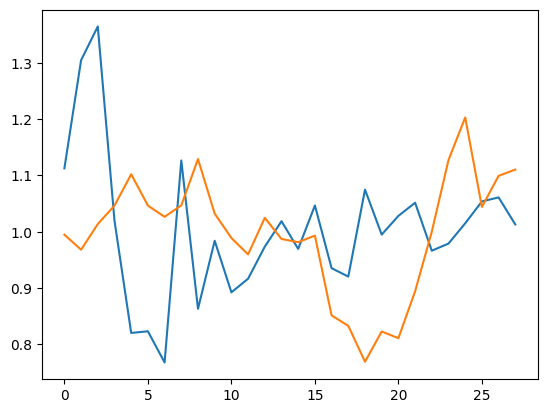

In [9]:
plt.plot(valid_data['target_1'].tolist()[:28])
plt.plot([x[0] for x in all_preds])